## A6.6 Sourcing & Analyzing Time-Series Data

### The following script contains the following:

#### 1. Import data, libraries, additional requirements
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Yach and Boat Sales Data
---------------------------------------------------------------------------------------------------------------------------
### 1. Import libraries, additional requirements and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings

In [2]:
# Displays all charts within notebook automatically
%matplotlib inline

# Turning off warning feature
import warnings
warnings.filterwarnings('ignore')

# Supress scientific notation for easier analysis profiling
pd.set_option('display.float_format', '{:.2f}'.format)

# Style the plot appearance
plt.style.use('fivethirtyeight')

In [3]:
#  Create/save project folder path
path = r"Boat Sales Analysis"

# Read data (csv file)
df = pd.read_csv(os.path.join(path, '02 Data', 'Prepared Data', 'boat_sales_final.csv'), encoding='ISO-8859-1', index_col=False)

In [4]:
df.head(5)

,Unnamed: 0,Category,Manufacturer,Specifications,Year Built,Year Built Condition,Length,Length Condition,Width,Width Condition,Material,Price,Price Condition,Currency,Country,State/Region,Location,# Views,Views Condition
0,0,Motor Yacht,Bayliner Power Boats,"Used Boat, Unleaded",1992.00,Old,7.70,Medium,2.46,Narrow,Plastic,14900,Low-value product,CHF,Switzerland,Le Landeron,NaN,3263,High Views
1,1,Hardtop,Princess Power Boats,"Used Boat, Diesel",1979.00,Old,11.12,Medium,3.88,Medium,GRP,35000,Low-value product,CHF,Switzerland,Neuenburgersee,Hauterive,2432,High Views
2,2,Bowrider,Windy Power Boats,"Used Boat, Diesel",2002.00,Mid,12.35,Medium,3.48,Medium,GRP,125900,Mid-value product,CHF,Switzerland,Lago Maggiore,6600 Locarno,2261,High Views
3,3,Hardtop,Pershing Power Boats,"Used Boat, Diesel",2009.00,Mid,20.30,Long,5.20,Wide,GRP,949000,High-value product,EUR,Germany,Baltic Sea,Neustadt In Holstein,2154,High Views
4,4,Sport Boat,Sea Ray Power Boats,"Used Boat, Unleaded",1993.00,Old,6.14,Short,2.34,Narrow,Plastic,19900,Low-value product,CHF,Switzerland,Murtensee,Avenches,2026,High Views


In [5]:
# Drop redundant column
df = df.drop(columns = ['Unnamed: 0'])

df.columns

Index(['Category', 'Manufacturer', 'Specifications', 'Year Built',
       'Year Built Condition', 'Length', 'Length Condition', 'Width',
       'Width Condition', 'Material', 'Price', 'Price Condition', 'Currency',
       'Country', 'State/Region', 'Location', '# Views', 'Views Condition'],
      dtype='object')

In [6]:
df.shape

(9888, 18)

In [7]:
# Create subset for multiple columns
sub = df[['Year Built', '# Views']]

# Save the subset to a new CSV file
sub.to_csv(os.path.join(path, '02 Data', 'Prepared Data', 'subset_data.csv'))

# View
sub

,Year Built,# Views
0,1992.00,3263
1,1979.00,2432
2,2002.00,2261
3,2009.00,2154
4,1993.00,2026
...,...,...
9883,2018.00,18
9884,2007.00,18
9885,2020.00,18
9886,2020.00,15


In [8]:
# Set max_rows option to None to display all rows
pd.set_option('display.max_rows', None)

sub['Year Built'].value_counts(dropna=False)

Year Built
2020.00    1279
2019.00     663
NaN         551
2008.00     457
2007.00     393
2006.00     393
2018.00     351
2017.00     314
2005.00     307
2009.00     303
2004.00     270
2016.00     227
2003.00     226
2010.00     222
2011.00     211
2001.00     202
2015.00     199
2000.00     195
2002.00     188
2012.00     175
2014.00     168
2013.00     160
1996.00     147
1999.00     144
1995.00     138
1992.00     135
1997.00     130
1991.00     130
1990.00     120
1998.00     118
1994.00     113
1993.00      95
1989.00      86
1988.00      72
1980.00      69
1987.00      61
1978.00      57
1985.00      55
2021.00      53
1986.00      50
1979.00      50
1984.00      40
1976.00      40
1981.00      40
1975.00      30
1974.00      30
1972.00      27
1983.00      27
1982.00      25
1973.00      23
1971.00      20
1970.00      17
1965.00      16
1967.00      16
1977.00      14
1968.00      12
1969.00      11
1963.00      11
1961.00      11
1910.00      10
1962.00       8
1922.00      

In [9]:
# Reset max_rows option to default
pd.reset_option('display.max_rows')

In [10]:
# Set index to 'Year Built' date
sub = sub.set_index('Year Built')

sub.head()

,# Views
Year Built,
1992.00,3263
1979.00,2432
2002.00,2261
2009.00,2154
1993.00,2026


In [11]:
type(sub)

pandas.core.frame.DataFrame

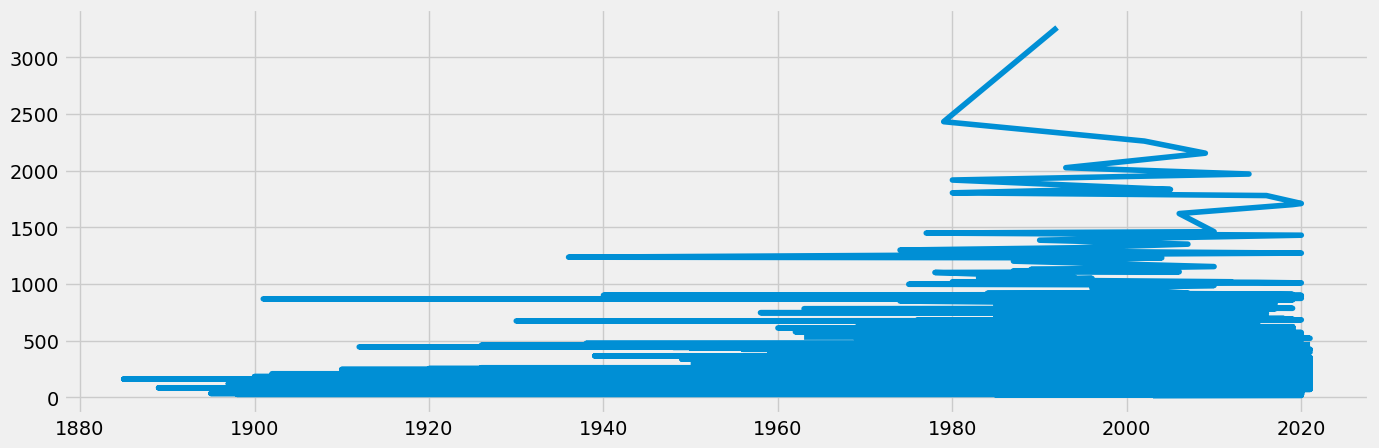

In [12]:
# Plot the data using matplotlib
plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization
plt.plot(sub)

- **Notes:** 'Year Built' column must be cleaned and aggregated into total views in order to smooth out the visualization by deriving less datapoints.

---------------------------------------------------------------------------------------------------------------------------
### 2. Subsetting, wrangling, and cleaning time-series data

In [13]:
# Resetting index to use the "Date" column as a filter
sub2 = sub.reset_index()

In [14]:
sub2.head()

,Year Built,# Views
0,1992.00,3263
1,1979.00,2432
2,2002.00,2261
3,2009.00,2154
4,1993.00,2026


In [15]:
# Create condition to view last 60 years
suby = sub2.loc[(sub2['Year Built'] > 1960) & (sub2['Year Built'] < 2020)] #exclusive #handles outliers well

In [16]:
suby.shape

(7824, 2)

In [17]:
suby.head()

,Year Built,# Views
0,1992.00,3263
1,1979.00,2432
2,2002.00,2261
3,2009.00,2154
4,1993.00,2026


In [18]:
# Check for missing values
suby.isnull().sum() 

Year Built    0
# Views       0
dtype: int64

In [19]:
# Set the "Date" column as the index

# Extract the year component from the 'Year Built' column
suby['Year'] = suby['Year Built'].astype(int)

# Set the 'Year' column as the index of the DataFrame
suby.set_index('Year', inplace=True)

# Drop the 'Year Built' column if needed
suby.drop(['Year Built'], axis=1, inplace=True)

suby

,# Views
Year,
1992,3263
1979,2432
2002,2261
2009,2154
1993,2026
...,...
2019,19
1985,19
2018,18


In [20]:
# Calculate the maximum number of views for each year
total_views = suby.groupby('Year')['# Views'].sum().reset_index()

# Merge max_views_yr back into the original DataFrame 'suby' based on the 'Year' column
total_views = pd.merge(suby, total_views, on='Year', suffixes=('', '_total_views'))

# Rename the newly added column
total_views.rename(columns={'# Views_total_views': 'Total # Views'}, inplace=True)

total_views

,Year,# Views,Total # Views
0,1992,3263,30259
1,1992,896,30259
2,1992,863,30259
3,1992,760,30259
4,1992,620,30259
...,...,...,...
7819,1968,70,1518
7820,1968,64,1518
7821,1968,64,1518
7822,1968,49,1518


In [21]:
# Group by 'Year' and sum the '# Views'
total_views = suby.groupby('Year')['# Views'].sum().reset_index()

# Rename the columns to match the desired output
total_views.columns = ['Year', 'Total # Views']

# Check the new DataFrame
total_views

,Year,Total # Views
0,1961,2094
1,1962,1724
2,1963,2641
3,1964,1002
4,1965,2609
5,1966,915
6,1967,4213
7,1968,1518
8,1969,3068
9,1970,3370


In [22]:
# Set the 'Year' column as the index
total_views.set_index('Year', inplace=True)

total_views

,Total # Views
Year,
1961,2094
1962,1724
1963,2641
1964,1002
1965,2609
1966,915
1967,4213
1968,1518
1969,3068


In [23]:
# Convert the index to datetime
total_views.index = pd.to_datetime(total_views.index, format='%Y')

# Save as csv file
total_views.to_csv(os.path.join(path, '02 Data', 'Prepared Data', 'total_boat_views_timeline'))

total_views

,Total # Views
Year,
1961-01-01,2094
1962-01-01,1724
1963-01-01,2641
1964-01-01,1002
1965-01-01,2609
1966-01-01,915
1967-01-01,4213
1968-01-01,1518
1969-01-01,3068


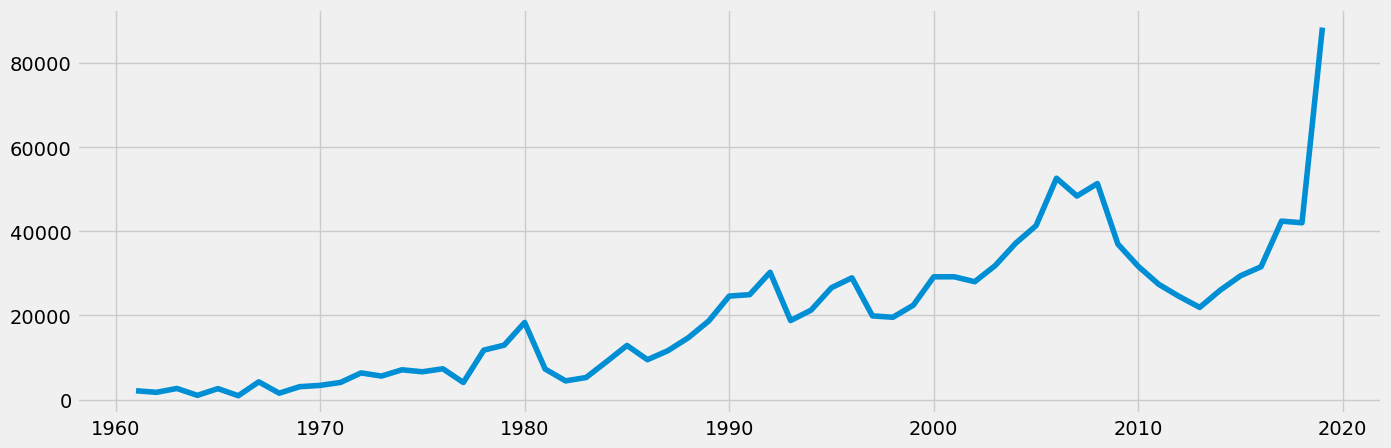

In [24]:
# Plot the new data set
plt.figure(figsize=(15,5), dpi=100)

plt.plot(total_views)

plt.savefig(os.path.join(path, '03 Analysis', 'Visualizations', 'total_views_timeline_1960-2020.png'))

- **Notes:**

- Clear increasing trend in total views over the years.
- Periods of significant growth, notably from 1980 to 1981 and 1988 to 1989.
- Steady and consistent growth in recent years, especially from the early 2000s onwards.
- Peak years of exceptionally high total views in 2007, 2008, and 2017.
- Yearly fluctuations in total views, influenced by factors like seasonality and content popularity.
- Sharp increase in total views observed in 2019, indicating a significant surge in engagement.

The data suggests a story of growth and increasing engagement over time, with notable peaks and fluctuations reflecting the dynamic nature of online viewership.

In [25]:
# Check for missing values (you shouldn't have any)
total_views.isnull().sum() 

Total # Views    0
dtype: int64

In [26]:
# Check for duplicates
dups = total_views.duplicated()
dups.sum()

# No duplicates, no concern here!

0

---------------------------------------------------------------------------------------------------------------------------
### 3. Time series analysis: decomposition

In [27]:
# Now you can decompose the time series using the seasonal_decompose function
decomposition = sm.tsa.seasonal_decompose(total_views, model='multiplicative')

In [28]:
from pylab import rcParams # This defines a fixed size for all special charts
rcParams['figure.figsize'] = 18, 7

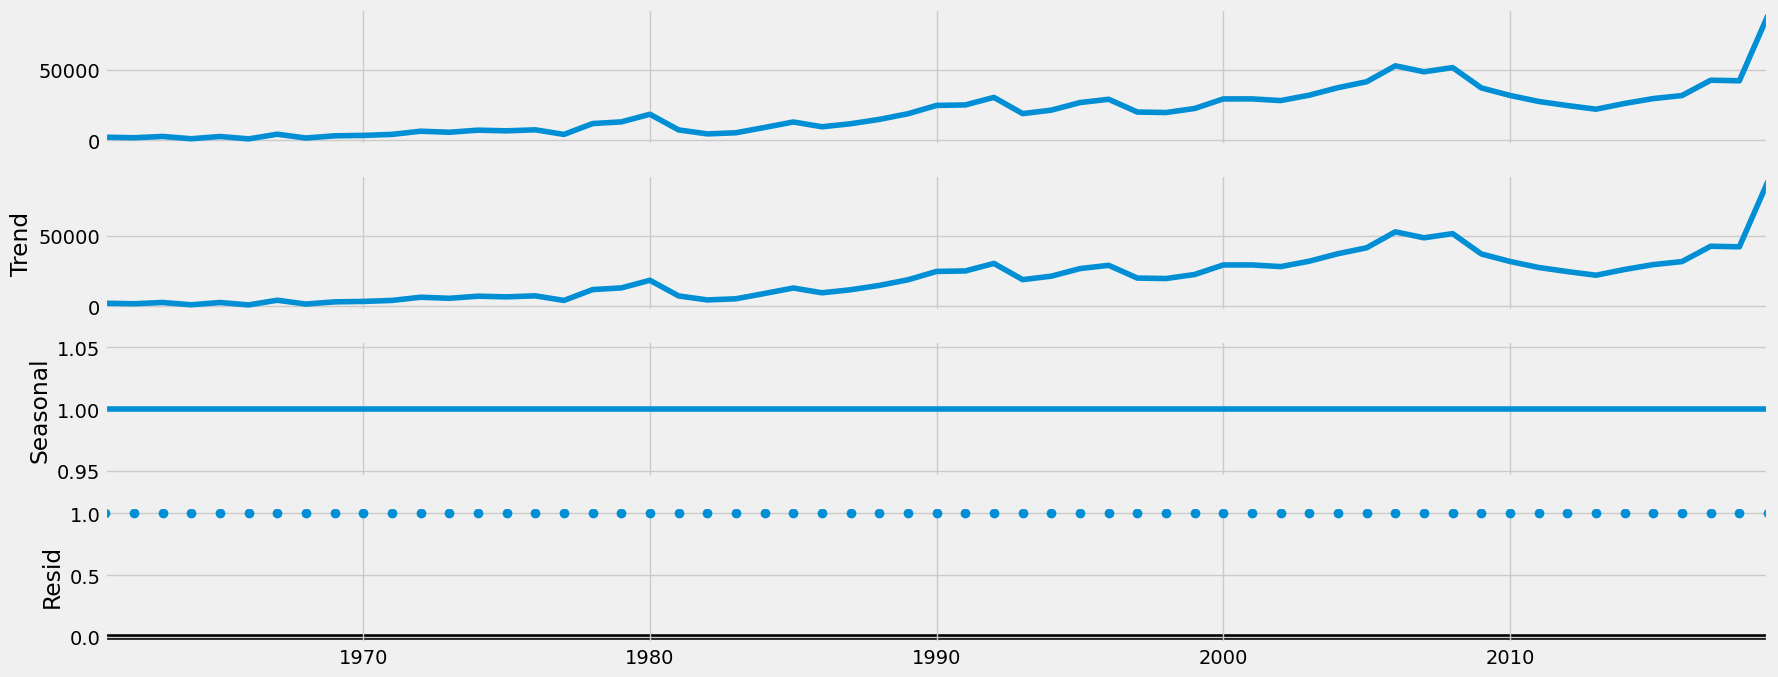

In [29]:
# Plot the separate components
decomposition.plot()

plt.savefig(os.path.join(path, '03 Analysis', 'Visualizations', 'decomposition.png'))
plt.show()

- **Notes:** 

---------------------------------------------------------------------------------------------------------------------------
### 4. Testing for stationarity

In [30]:
# The adfuller() function will import from the model from statsmodels for the test
# Define a function that prints the correct output from that array
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(total_views['Total # Views'])

Dickey-Fuller Stationarity test:
Test Statistic                 0.83
p-value                        0.99
Number of Lags Used           10.00
Number of Observations Used   48.00
Critical Value (1%)           -3.57
Critical Value (5%)           -2.92
Critical Value (10%)          -2.60
dtype: float64


- **Notes from this test result:**

The test statistic is greater than the critical values, indicating that we fail to reject the null hypothesis.
The p-value is very high (1.00), further suggesting that we do not have enough evidence to reject the null hypothesis.
Based on these results, we cannot conclude that the time series is stationary. It is likely non-stationary.

---------------------------------------------------------------------------------------------------------------------------

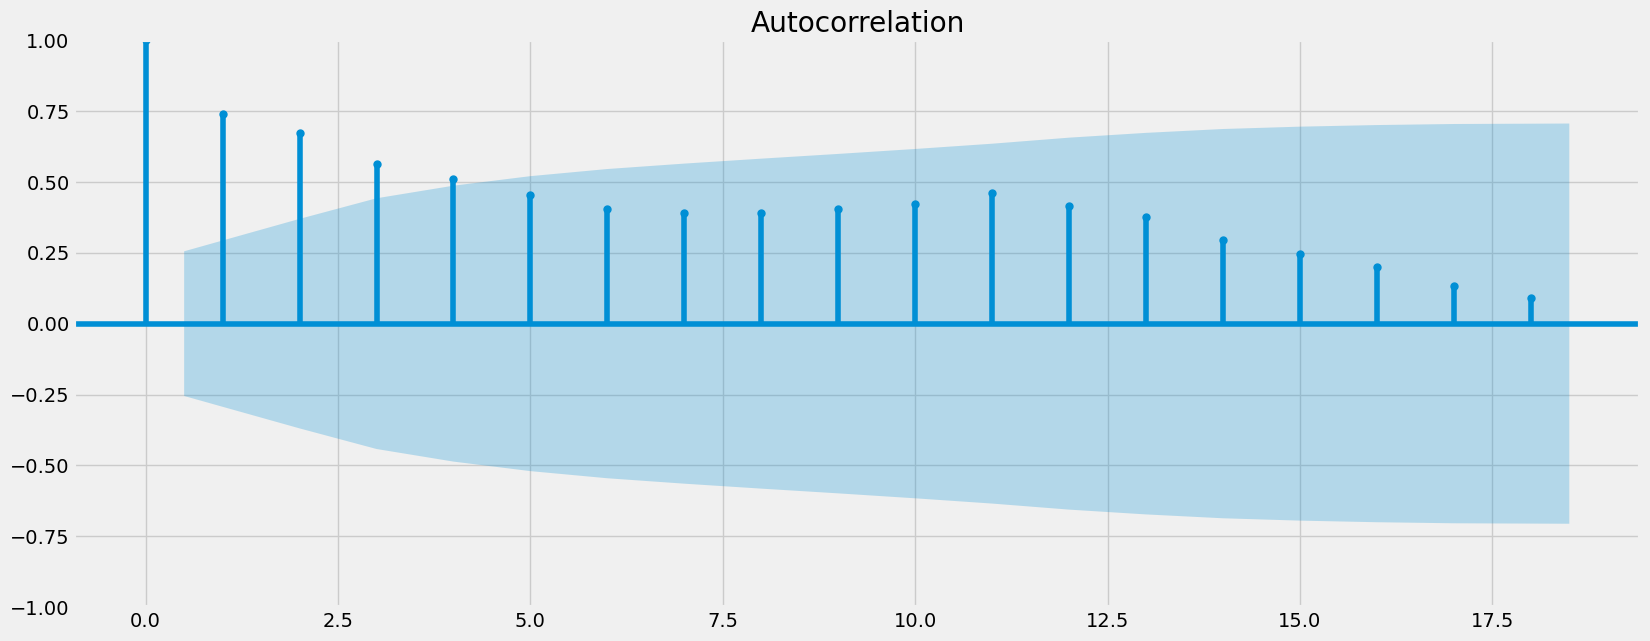

In [31]:
# Check out a plot of autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Import the autocorrelation and partial correlation plots

plot_acf(total_views)

plt.savefig(os.path.join(path, '03 Analysis', 'Visualizations', 'stationary_auto_corr.png'))
plt.show()

---------------------------------------------------------------------------------------------------------------------------
### 5. Stationarizing the Yacht and Boat Sales Data

In [32]:
# Differencing the data for stationarity
data_diff = total_views - total_views.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [33]:
data_diff.dropna(inplace = True) # Removing the missing values that came about as a result of the differencing
# Must be removed to run dickey_fuller test

In [34]:
data_diff.head()

,Total # Views
Year,
1962-01-01,-370.00
1963-01-01,917.00
1964-01-01,-1639.00
1965-01-01,1607.00
1966-01-01,-1694.00


In [35]:
data_diff.columns

Index(['Total # Views'], dtype='object')

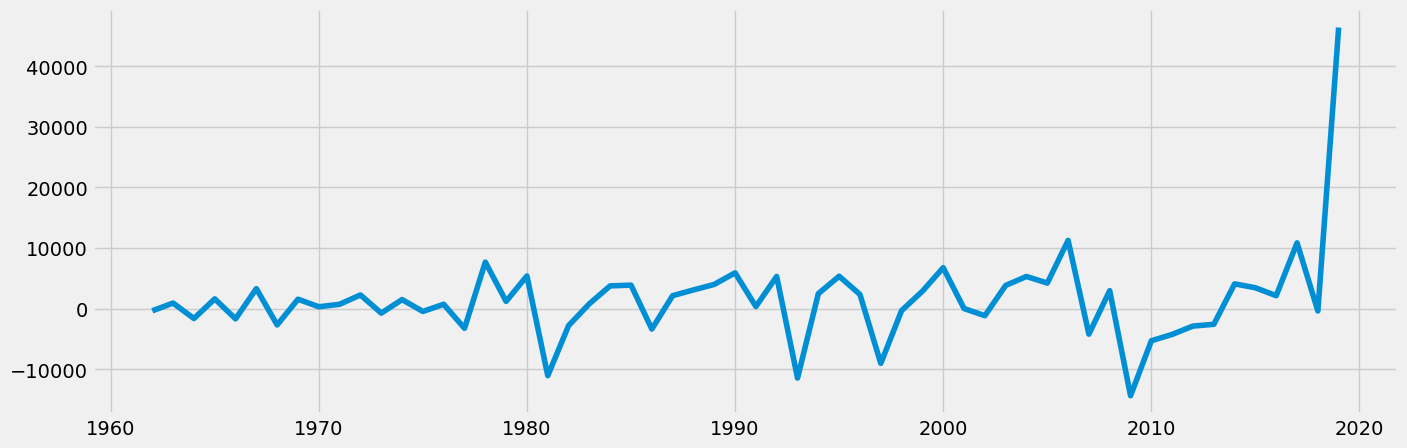

In [36]:
# Check out what the differencing did to the time-series curve
plt.figure(figsize=(15,5), dpi=100)

plt.plot(data_diff)

plt.savefig(os.path.join(path, '03 Analysis', 'Visualizations', 'differencing_line_chart.png'))

In [37]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -5.59
p-value                        0.00
Number of Lags Used            9.00
Number of Observations Used   48.00
Critical Value (1%)           -3.57
Critical Value (5%)           -2.92
Critical Value (10%)          -2.60
dtype: float64


- **Notes:**

- **Critical Value (1%) (-3.57):** At the 1% significance level, if the test statistic is less than this value, we reject the null hypothesis. 
- **Critical Value (5%) (-2.92):** Similarly, at the 5% significance level, if the test statistic is less than this value, we reject the null hypothesis.
- **Critical Value (10%) (-2.60):** At the 10% significance level, if the test statistic is less than this value, we reject the null hypothesis.

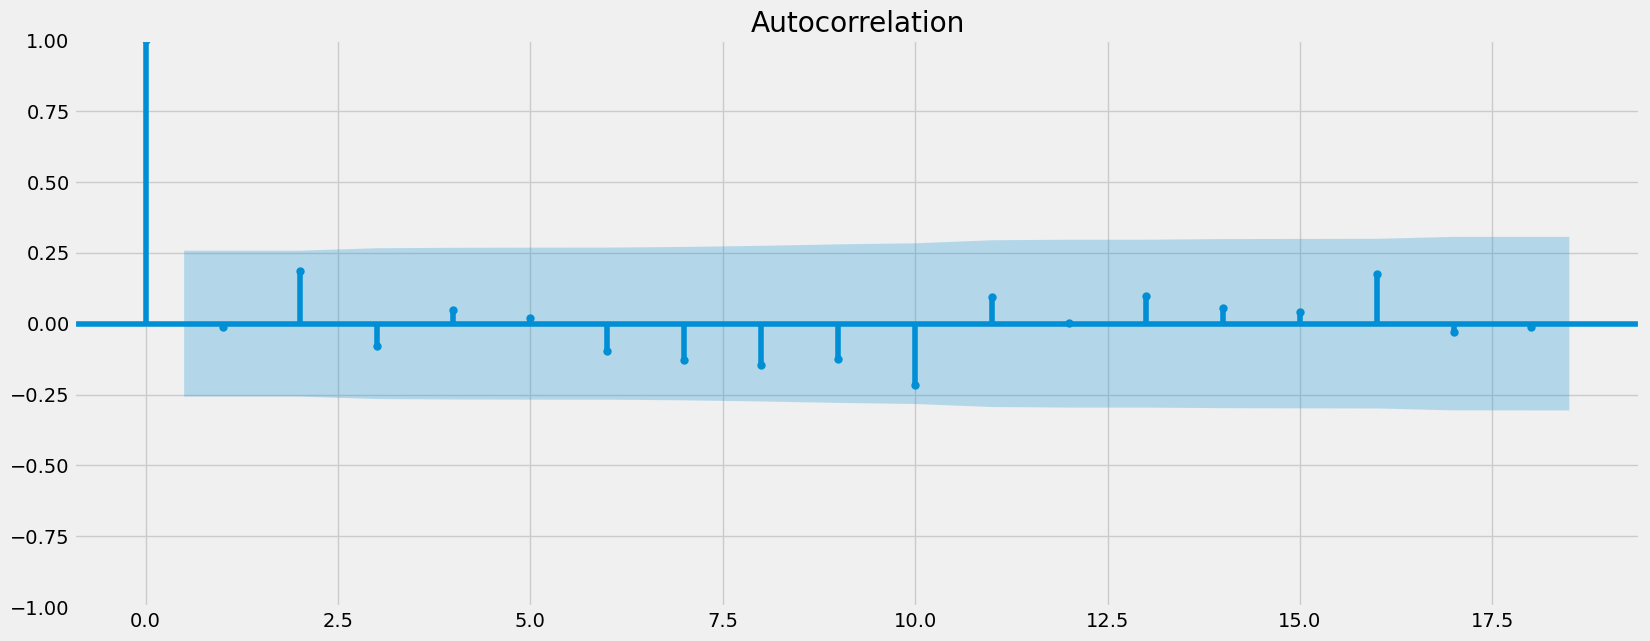

In [38]:
plot_acf(data_diff)

plt.savefig(os.path.join(path, '03 Analysis', 'Visualizations', 'stationary_auto_corr2.png'))
plt.show()

Based on these insights:

- The test statistic (-5.59) is much lower than the critical values (-3.57, -2.92, -2.60), indicating strong evidence against the null hypothesis of non-stationarity.
- The p-value of 0.00 further supports this conclusion, indicating very strong evidence against the null hypothesis.
- Therefore, we can conclude that the time series is stationary.
---------------------------------------------------------------------------------------------------------------------------